# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Изучение данных из файла

Импортируем библиотеки, с которыми будем работать

In [2]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
import time
import warnings
warnings.filterwarnings('ignore')

Сохраним данные в переменную `df` и посмотрим первые 5 строк датасета:

In [3]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим описательную статистику по каждому столбцу датафрейма:

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Видим выбросы и аномальные значения в некоторых столбцах, обработаем их в процессе предобработки данных. Начнем со стиля заголовков.
Приведем названия столбцов в нижний регистр:

### Стиль заголовков

In [5]:
df.columns = df.columns.str.lower()
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Переименуем столбцы в соответствии со змеиным стилем:

In [6]:
df = df.rename(columns={'datecrawled': 'date_crawled', 
                        'vehicletype': 'vehicle_type',
                       'registrationyear' : 'registration_year',
                       'registrationmonth' : 'registration_month',
                       'fueltype' : 'fuel_type',
                       'notrepaired' : 'not_repaired',
                       'datecreated' : 'date_created',
                       'numberofpictures' : 'number_of_pictures',
                       'postalcode' : 'postal_code',
                       'lastseen' : 'last_seen'})

### Дубликаты

Проверим наличие дубликатов в датасете и удалим их:

In [7]:
df.duplicated().sum()

4

In [8]:
df = df.drop_duplicates()

Удалили дубликаты, теперь посмотрим на пропуски.

### Пропуски значений

In [9]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Пропущенные значения есть в 5 столбцах:
* тип автомобильного кузова, 
* тип коробки передач,
* модель автомобиля,
* тип топлива,
* была машина в ремонте или нет.  

Посмотрим на уникальные значения в столбце "Тип автомобильного кузова":

In [10]:
df['vehicle_type'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

У нас нет инструментов, чтобы достоверно восстановить пропущенные значения, поэтому исключим эти строки из анализа:

In [11]:
df = df.dropna(subset=['vehicle_type'])
df.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                9863
power                     0
model                 12877
kilometer                 0
registration_month        0
fuel_type             15600
brand                     0
not_repaired          50583
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Посмотрим уникальные значения столбца "Тип коробки передач":

In [12]:
df['gearbox'].value_counts()

manual    244727
auto       62285
Name: gearbox, dtype: int64

Попробуем заменить пропуски на наиболее часто встречающееся значение - manual (ручная коробка передач).

In [13]:
df['gearbox'] = df['gearbox'].fillna(value='manual')
df.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                 12877
kilometer                 0
registration_month        0
fuel_type             15600
brand                     0
not_repaired          50583
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Посмотрим на значения в столбце "Модель":

In [14]:
df['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

У нас нет инструментов, чтобы достоверно восстановить пропущенные значения, поэтому исключим эти строки из анализа:

In [15]:
df = df.dropna(subset=['model'])
df.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             12751
brand                     0
not_repaired          46005
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Посмотрим на пропуски в столбце "Тип топлива":

In [16]:
df['fuel_type'].value_counts()

petrol      194156
gasoline     91515
lpg           4698
cng            501
hybrid         194
other          119
electric        64
Name: fuel_type, dtype: int64

Заменим пропуски на наиболее часто встречающийся вариант - petrol (бензин):

In [17]:
df['fuel_type'] = df['fuel_type'].fillna(value='petrol')
df.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
not_repaired          46005
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Предположим, что владельцы не указывали никаких данных о ремонте в случаях, когда ремонта не было. Исходя из этого предположения, заменим пропуски в столбце "Была машина в ремонте или нет" на вариант "нет":

In [18]:
df['not_repaired'].value_counts()

no     227603
yes     30390
Name: not_repaired, dtype: int64

In [19]:
df['not_repaired'] = df['not_repaired'].fillna(value='no')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303998 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        303998 non-null  object
 1   price               303998 non-null  int64 
 2   vehicle_type        303998 non-null  object
 3   registration_year   303998 non-null  int64 
 4   gearbox             303998 non-null  object
 5   power               303998 non-null  int64 
 6   model               303998 non-null  object
 7   kilometer           303998 non-null  int64 
 8   registration_month  303998 non-null  int64 
 9   fuel_type           303998 non-null  object
 10  brand               303998 non-null  object
 11  not_repaired        303998 non-null  object
 12  date_created        303998 non-null  object
 13  number_of_pictures  303998 non-null  int64 
 14  postal_code         303998 non-null  int64 
 15  last_seen           303998 non-null  object
dtypes:

Удалим столбцы, которые не имеют существенного влияния на целевой признак - цену автомобиля:
* дата скачивания анкеты из базы,
* год регистрации автомобиля,
* месяц регистрации автомобиля,
* дата создания анкеты,
* количество фотографий автомобиля,
* почтовый индекс владельца анкеты (пользователя),
* дата последней активности пользователя:

In [20]:
df = df.drop(['date_crawled', 'registration_year','registration_month', 'date_created', 'number_of_pictures',
              'postal_code', 'last_seen'], 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303998 entries, 2 to 354368
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         303998 non-null  int64 
 1   vehicle_type  303998 non-null  object
 2   gearbox       303998 non-null  object
 3   power         303998 non-null  int64 
 4   model         303998 non-null  object
 5   kilometer     303998 non-null  int64 
 6   fuel_type     303998 non-null  object
 7   brand         303998 non-null  object
 8   not_repaired  303998 non-null  object
dtypes: int64(3), object(6)
memory usage: 23.2+ MB


### Аномальные значения

Посмотрим на выбросы и аномальные значения:

In [21]:
df.describe()

,price,power,kilometer
count,303998.000000,303998.000000,303998.000000
mean,4711.228321,115.162731,128452.703636
std,4592.428261,179.546750,36822.041948
min,0.000000,0.000000,5000.000000
25%,1250.000000,75.000000,125000.000000
50%,2999.000000,107.000000,150000.000000
75%,6890.000000,144.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


Построим гистограмму "Цена автомобиля":

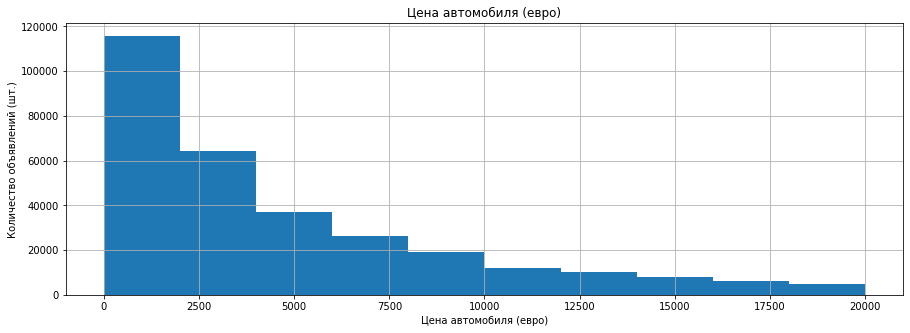

In [22]:
df['price'].plot(
    kind='hist',
    alpha=1.0,
    title='Цена автомобиля (евро)',
    grid=True,
    figsize=(15,5),
    fontsize=10)
plt.xlabel('Цена автомобиля (евро)')
plt.ylabel('Количество объявлений (шт.)')
plt.show()

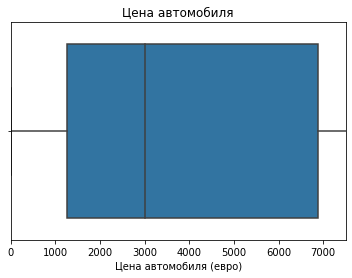

In [23]:
sbn.boxplot(df.price)
plt.title('Цена автомобиля')
plt.xlim(0, 7500)
plt.xlabel('Цена автомобиля (евро)')
plt.show()

Цена автомобиля - целевой признак и передавать в модель данные с нулевой ценой нецелесообразно. Удалим все значения, равные нулю:

In [24]:
df = df[(df['price'] != 0)]
df['price'].describe()

count    297906.000000
mean       4807.570130
std        4588.955575
min           1.000000
25%        1300.000000
50%        3100.000000
75%        6950.000000
max       20000.000000
Name: price, dtype: float64

Построим гистограмму "Мощность автомобиля":

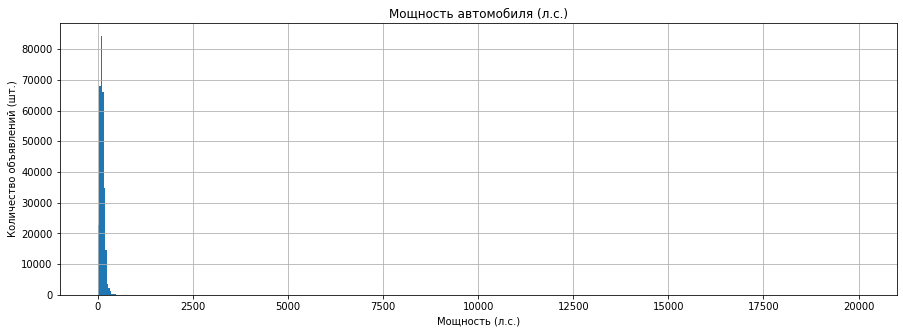

In [25]:
df['power'].plot(
    kind='hist',
    alpha=1.0,
    bins=500,
    title='Мощность автомобиля (л.с.)',
    grid=True,
    figsize=(15,5),
    fontsize=10)
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Количество объявлений (шт.)')
plt.show()

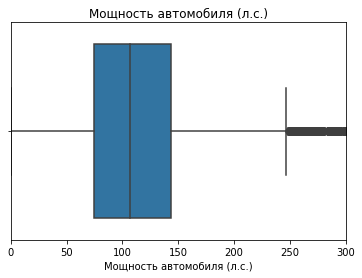

In [26]:
sbn.boxplot(df.power)
plt.title('Мощность автомобиля (л.с.)')
plt.xlim(0, 300)
plt.xlabel('Мощность автомобиля (л.с.)')
plt.show()

На графиках мы видим выбросы, которые появились вероятнее всего из-за ошибок пользователей при заполнении объявлений, поэтому удалим данные с мощностью автомобиля менее 5 лошадиных сил и более 250 лошадиных сил:

In [27]:
df = df[(df['power'] > 5) & (df['power'] < 250)]
df['power'].describe()

count    269076.000000
mean        116.722551
std          45.264665
min           6.000000
25%          75.000000
50%         110.000000
75%         145.000000
max         249.000000
Name: power, dtype: float64

Построим гистограмму "Пробег":

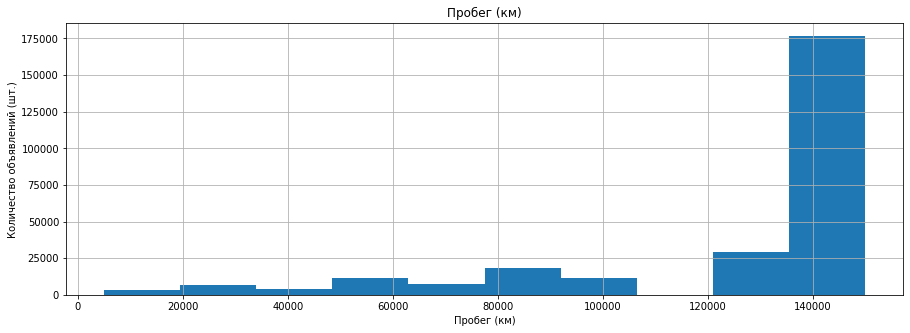

In [28]:
df['kilometer'].plot(
    kind='hist',
    alpha=1.0,
    title='Пробег (км)',
    grid=True,
    figsize=(15,5),
    fontsize=10)
plt.xlabel('Пробег (км)')
plt.ylabel('Количество объявлений (шт.)')
plt.show()

Явных аномалий и выбросов мы не видим, в основном все машины с пробегом более 120 тыс.км., что нормально для сервиса по продаже подержанных авто.

### Вывод

В ходе подготовки данных мы обнаружили несколько проблем:

- столбцы с бесполезной информацией,
- нарушения в стиле заголовков,
- пропущенные значения,
- дубликаты,
- выбросы и аномальные значения.


Мы исправили заголовки, чтобы упростить работу с таблицей, удалили лишние столбцы. 

Удалили пропущенные значения в столбцах "Тип автомобильного кузова", "Модель автомобиля", поскольку восстановить их достоверно невозможно. В столбцах "Тип коробки передач", "Тип топлива" и "Была машина в ремонте или нет" сделали замену пропусков на наиболее часто встречающееся значение.

Теперь данные готовы к дальнейшей работе.

## Обучение моделей

### Мультиколлинеарность
Проведем корреляционный анализ факторов, для этого посчитаем коэффициент корреляции Пирсона.

In [29]:
corr_matrix = df.corr().round(2)
corr_matrix

,price,power,kilometer
price,1.00,0.49,-0.41
power,0.49,1.00,0.12
kilometer,-0.41,0.12,1.00


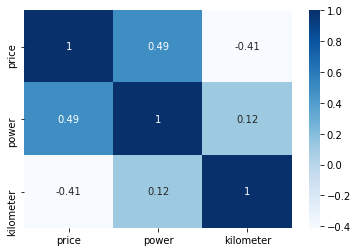

In [30]:
sbn.heatmap(corr_matrix, 
            annot=True, 
            cmap='Blues')
plt.show()

Наблюдаем среднюю положительную корреляцию между мощностью автомобиля и ценой, а также среднюю отрицательную корреляцию между пробегом и ценой - чем больше пробег, тем дешевле автомобиль. Удалять никакие признаки не будем, поскольку сильной корреляции не выявили.  
Категориальные признаки преобразуем с помощью метода Ordinal Encoding, для этого сначала создадим копию нашего датафрейма и сохраним в переменную `df_ordinal`:

In [31]:
df_ordinal = df.copy()

In [32]:
category = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
encoder = OrdinalEncoder()
df_ordinal[category] = encoder.fit_transform(df_ordinal[category])
df_ordinal

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2,9800,6.0,0.0,163,117.0,125000,2.0,14.0,0.0
3,1500,5.0,1.0,75,116.0,150000,6.0,37.0,0.0
4,3600,5.0,1.0,69,101.0,90000,2.0,31.0,0.0
5,650,4.0,1.0,102,11.0,150000,6.0,2.0,1.0
6,2200,1.0,1.0,109,8.0,150000,6.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...
354359,7900,4.0,1.0,140,116.0,150000,2.0,37.0,0.0
354362,3200,4.0,1.0,225,140.0,150000,6.0,30.0,1.0
354366,1199,1.0,0.0,101,106.0,125000,6.0,32.0,0.0
354367,9200,0.0,1.0,102,222.0,150000,2.0,37.0,0.0


Теперь выделим в исходных данных:
* **признаки**: vehicle_type, gearbox, power, model, kilometer, fuel_type, brand, not_repaired
* **целевой признак**: price

In [33]:
features = df_ordinal.drop(['price'], axis=1)
target = df_ordinal['price']

Разделим данные на обучающую и тестовую выборки в соотношении 75:25

In [34]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=12345)

Приведём численные признаки к одному масштабу.

In [35]:
numeric = ['power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_test.shape)

(201807, 8)
(67269, 8)


Удалим лишние переменные, чтобы освободить память и вычислительные мощности для более быстрого обучения:

In [36]:
del df_ordinal
del features
del target

### Модель линейной регрессии
Для оценки качества модели линейной регрессии используем кросс-валидацию.

In [37]:
%%time

mse_linreg = cross_val_score(LinearRegression(), features_train, target_train, cv=5, scoring = 'neg_root_mean_squared_error')
#rmse_linreg = np.mean(np.sqrt(np.abs(mse_linreg)))
rmse_linreg = mse_linreg.mean()
# predictions = linreg.predict(features_valid)
print('RMSE линейной регрессии:', rmse_linreg)
print()

RMSE линейной регрессии: -3045.893791824984

CPU times: user 374 ms, sys: 524 ms, total: 898 ms
Wall time: 870 ms


### Модель решающего дерева

In [38]:
%%time

# задаем параметры для модуля GridSearch 
param_grid = {
 'max_depth': [1, 10],
 'min_samples_split': [8, 10, 12],
 }

# инициализируем модель
dt_reg = DecisionTreeRegressor(random_state=12345)

# ищем лучшие параметры 
grid_dt = GridSearchCV(estimator = dt_reg, 
                       param_grid = param_grid, 
                       cv= 5, 
                       n_jobs = -1, 
                       scoring = 'neg_root_mean_squared_error') 

# обучаем модель на тренировочных данных
grid_dt.fit(features_train, target_train)

# получаем лучшие параметры модели
print('Лучшие параметры модели решающего дерева:', grid_dt.best_params_)
print()

# получаем лучшую оценку 
best_score = grid_dt.best_score_.mean()
print('RMSE решающего дерева:', best_score)
print()

Лучшие параметры модели решающего дерева: {'max_depth': 10, 'min_samples_split': 8}

RMSE решающего дерева: -2488.870125369635

CPU times: user 5.22 s, sys: 32.1 ms, total: 5.25 s
Wall time: 5.28 s


### Модель случайного леса

In [39]:
%%time

# задаем параметры для модуля GridSearch 
param_grid = {
 'max_depth': [1, 10],
 'n_estimators': [100, 200]
}

# инициализируем модель
forest_reg = RandomForestRegressor(random_state=12345)

# ищем лучшие параметры 
grid_forest = GridSearchCV(estimator = forest_reg, 
                            param_grid = param_grid, 
                            cv= 5, 
                            n_jobs = -1, 
                            scoring='neg_root_mean_squared_error') 

# обучаем модель на тренировочных данных
grid_forest.fit(features_train, target_train)

# получаем лучшие параметры модели
print('Лучшие параметры модели случайного леса:', grid_forest.best_params_)
print()

# получаем лучшую оценку 
best_score_forest = grid_forest.best_score_
rmse_forest = best_score.mean()
print('RMSE случайного леса:', rmse_forest)
print()

Лучшие параметры модели случайного леса: {'max_depth': 10, 'n_estimators': 200}

RMSE случайного леса: -2488.870125369635

CPU times: user 6min 17s, sys: 370 ms, total: 6min 18s
Wall time: 6min 18s


### LightGBM

Для модели градиентного бустинга не подойдут кодированные признаки, поэтому поменяем тип данных в категориальных признаках, для этого создадим копию исходного датасета:

In [40]:
df_lgbm = df.copy()

In [41]:
# меняем тип данных на category
categorial_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
df_lgbm[categorial_columns] = df_lgbm[categorial_columns].astype('category')
df_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269076 entries, 2 to 354368
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         269076 non-null  int64   
 1   vehicle_type  269076 non-null  category
 2   gearbox       269076 non-null  category
 3   power         269076 non-null  int64   
 4   model         269076 non-null  category
 5   kilometer     269076 non-null  int64   
 6   fuel_type     269076 non-null  category
 7   brand         269076 non-null  category
 8   not_repaired  269076 non-null  category
dtypes: category(6), int64(3)
memory usage: 10.0 MB


In [42]:
df_lgbm

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2,9800,suv,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,manual,140,golf,150000,gasoline,volkswagen,no
354362,3200,sedan,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,manual,102,transporter,150000,gasoline,volkswagen,no


Выделим признаки и целевой признак:

In [41]:
features_lgbm = df_lgbm.drop(['price'], axis=1)
target_lgbm = df_lgbm['price']

Разделим данные на обучающую и тестовую выборки в соотношении 75:25

In [42]:
features_train_lgbm, features_test_lgbm, target_train_lgbm, target_test_lgbm = train_test_split(features_lgbm, 
                                                                            target_lgbm, 
                                                                            test_size=0.25, 
                                                                            random_state=12345)

Приведём численные признаки к одному масштабу:

In [43]:
numeric = ['power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train_lgbm[numeric])
features_train_lgbm[numeric] = scaler.transform(features_train_lgbm[numeric])
features_test_lgbm[numeric] = scaler.transform(features_test_lgbm[numeric])

Удалим лишние переменные, чтобы освободить память и вычислительные мощности для более быстрого обучения:

In [44]:
del df_lgbm
del features_lgbm
del target_lgbm

*Стоит отметить, что время обучения модели при работе локально составляет около 16 секунд. При работе в среде Практикума время обучения варьируется от 2 до 40 минут в лучшем случае*

In [45]:
%%time
# задаем параметры для модуля GridSearch 
param_grid = {'max_depth': range(10, 21, 5),
              'n_estimators': range(10, 51, 10)}
  
# инициализируем модель
model = LGBMRegressor(learning_rate = 0.1, n_jobs = -1, random_state=12345)
# model = LGBMRegressor(n_jobs = -1, random_state=12345)

# ищем лучшие параметры 
grid_model = GridSearchCV(estimator = model, 
                            param_grid = param_grid, 
                            cv= 5, 
                            n_jobs = -1, 
                            scoring='neg_root_mean_squared_error',
                            verbose = 10) 

# обучаем модель на тренировочных данных
grid_model.fit(features_train_lgbm, target_train_lgbm)

# получаем лучшие параметры модели
print('Лучшие параметры модели LGBMR:', grid_model.best_params_)
print()

# получаем лучшую оценку
best_score_lgbm = grid_model.best_score_
rmse_lgbm = best_score_lgbm.mean()
print('RMSE для модели LGBMR:', rmse_lgbm)
print()

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=10, n_estimators=10..............................
[CV 1/5; 1/15] END ............max_depth=10, n_estimators=10; total time=   0.8s
[CV 2/5; 1/15] START max_depth=10, n_estimators=10..............................
[CV 2/5; 1/15] END ............max_depth=10, n_estimators=10; total time=   0.8s
[CV 3/5; 1/15] START max_depth=10, n_estimators=10..............................
[CV 3/5; 1/15] END ............max_depth=10, n_estimators=10; total time=   0.8s
[CV 4/5; 1/15] START max_depth=10, n_estimators=10..............................
[CV 4/5; 1/15] END ............max_depth=10, n_estimators=10; total time=   0.8s
[CV 5/5; 1/15] START max_depth=10, n_estimators=10..............................
[CV 5/5; 1/15] END ............max_depth=10, n_estimators=10; total time=   0.7s
[CV 1/5; 2/15] START max_depth=10, n_estimators=20..............................
[CV 1/5; 2/15] END ............max_depth=10, n_e

Итак мы обучили 4 модели, теперь проверим их работу на тестовой выборке и сравним полученные результаты.

## Анализ моделей

Создадим пустые списки:
* время обучения,
* скорость предсказания,
* качество предсказания:

In [46]:
training_time = []
prediction_speed = []
prediction_quality = []

Обучим модели на тестовых выборках, найдем для каждой модели время обучения, скорость предсказания, качество предсказания:

### Модель линейной регрессии

In [47]:
# инициализируем модель 
linreg = LinearRegression()

In [48]:
# обучаем модель на тренировочной выборке
st = time.time()
linreg.fit(features_train, target_train)
et = time.time()
elapsed_time_linreg = et - st
training_time.append(elapsed_time_linreg)
print('Время обучения модели линейной регрессии:', elapsed_time_linreg)

Время обучения модели линейной регрессии: 0.08533763885498047


In [49]:
# находим предсказания на тестовой выборке
st = time.time()
predictions_linreg = linreg.predict(features_test)
et = time.time()
elapsed_time_linreg_pred = et - st
prediction_speed.append(elapsed_time_linreg_pred)
print('Скорость предсказания модели линейной регрессии:', elapsed_time_linreg_pred)

Скорость предсказания модели линейной регрессии: 0.004705667495727539


In [50]:
# оцениваем модель
rmse_linreg_test = mean_squared_error(target_test, predictions_linreg)**0.5
prediction_quality.append(rmse_linreg_test)
print('RMSE линейной регрессии:', rmse_linreg_test)

RMSE линейной регрессии: 3064.8751613804366


### Модель решающего дерева

Лучшие параметры модели решающего дерева: {'max_depth': 10, 'min_samples_split': 8}

In [51]:
# инициализируем модель
dt_reg = DecisionTreeRegressor(random_state=12345, max_depth = 10, min_samples_split = 8)

In [52]:
# обучаем модель на тренировочной выборке
st = time.time()
dt_reg.fit(features_train, target_train)
et = time.time()
elapsed_time_dt = et - st
training_time.append(elapsed_time_dt)
print('Время обучения модели решающего дерева:', elapsed_time_dt, 'секунд')

Время обучения модели решающего дерева: 0.25532031059265137 секунд


In [53]:
# находим предсказания на тестовой выборке
st = time.time()
predictions_dt = dt_reg.predict(features_test)
et = time.time()
elapsed_time_dt_pred = et - st
prediction_speed.append(elapsed_time_dt_pred)
print('Скорость предсказания модели решающего дерева:', elapsed_time_dt_pred, 'секунд')

Скорость предсказания модели решающего дерева: 0.008150100708007812 секунд


In [54]:
# оцениваем модель
rmse_dt_test = mean_squared_error(target_test, predictions_dt)**0.5
prediction_quality.append(rmse_dt_test)
print('RMSE решающего дерева:', rmse_dt_test)

RMSE решающего дерева: 2482.156336477641


### Модель случайного леса
Лучшие параметры модели случайного леса: {'max_depth': 10, 'n_estimators': 200}

In [55]:
# инициализируем модель
forest_reg = RandomForestRegressor(random_state=12345, max_depth = 10, n_estimators = 200)

In [56]:
# обучаем модель на тренировочной выборке
st = time.time()
forest_reg.fit(features_train, target_train)
et = time.time()
elapsed_time_forest = et - st
training_time.append(elapsed_time_forest)
print('Время обучения модели случайного леса:', elapsed_time_forest, 'секунд')

Время обучения модели случайного леса: 32.64129376411438 секунд


In [57]:
# находим предсказания на тестовой выборке
st = time.time()
predictions_forest = forest_reg.predict(features_test)
et = time.time()
elapsed_time_forest_pred = et - st
prediction_speed.append(elapsed_time_forest_pred)
print('Скорость предсказания модели случайного леса:', elapsed_time_forest_pred, 'секунд')

Скорость предсказания модели случайного леса: 1.056225299835205 секунд


In [58]:
# оцениваем модель
rmse_forest_test = mean_squared_error(target_test, predictions_forest)**0.5
prediction_quality.append(rmse_forest_test)
print('RMSE случайного леса:', rmse_forest_test)

RMSE случайного леса: 2399.0665458568396


### LightGBM
Лучшие параметры модели LGBMR: {'max_depth': 20, 'n_estimators': 50}

In [59]:
# инициализируем модель
model_LGBM = LGBMRegressor(learning_rate = 0.1, n_jobs = -1, random_state=12345, max_depth = 15, n_estimators = 50)

In [60]:
# обучаем модель на тренировочной выборке
st = time.time()
model_LGBM.fit(features_train_lgbm, target_train_lgbm)
et = time.time()
elapsed_time_lgbm = et - st
training_time.append(elapsed_time_lgbm)
print('Время обучения модели LGBMR:', elapsed_time_lgbm, 'секунд')

Время обучения модели LGBMR: 2.426097869873047 секунд


In [61]:
# находим предсказания на тестовой выборке
st = time.time()
predictions_LGBM = model_LGBM.predict(features_test_lgbm)
et = time.time()
elapsed_time_lgbm_pred = et - st
prediction_speed.append(elapsed_time_lgbm_pred)
print('Скорость предсказания модели LGBMR:', elapsed_time_lgbm_pred, 'секунд')

Скорость предсказания модели LGBMR: 0.39732813835144043 секунд


In [62]:
# оцениваем модель
rmse_LGBM_test = mean_squared_error(target_test_lgbm, predictions_LGBM)**0.5
prediction_quality.append(rmse_LGBM_test)
print('RMSE для модели LGBMR:', rmse_LGBM_test)

RMSE для модели LGBMR: 2253.34309878118


### Константная модель

Проверим модели на адекватность с помощью константной модели DummyRegressor.

In [63]:
# инициализируем модель
const = DummyRegressor(strategy='median')

In [64]:
# обучаем модель на тренировочных данных
st = time.time()
const.fit(features_train, target_train)
et = time.time()
elapsed_time_const = et - st
training_time.append(elapsed_time_const)
print('Время обучения константной модели:', elapsed_time_const, 'секунд')

Время обучения константной модели: 0.0029075145721435547 секунд


In [65]:
# находим предсказания на тестовой выборке
st = time.time()
predictions_const = const.predict(features_test)
et = time.time()
elapsed_time_const_pred = et - st
prediction_speed.append(elapsed_time_const_pred)
print('Скорость предсказания константной модели:', elapsed_time_const_pred, 'секунд')

Скорость предсказания константной модели: 0.0006594657897949219 секунд


In [66]:
# оцениваем модель
rmse_const = mean_squared_error(target_test, predictions_const)**0.5
prediction_quality.append(rmse_const)
print('RMSE для константной модели:', rmse_const)

RMSE для константной модели: 4813.565401402809


Для наглядного сравнения добавим полученные данные в таблицу и сохраним ее в переменную `df_models`.

In [67]:
df_models = pd.DataFrame([training_time, prediction_speed, prediction_quality],
             index=['Время обучения', 'Скорость предсказания', 'Качество предсказания'],
             columns=['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM', 'Константная модель'])
df_models.T

,Время обучения,Скорость предсказания,Качество предсказания
Линейная регрессия,0.085338,0.004706,3064.875161
Дерево решений,0.255320,0.008150,2482.156336
Случайный лес,32.641294,1.056225,2399.066546
LightGBM,2.426098,0.397328,2253.343099
Константная модель,0.002908,0.000659,4813.565401


### Вывод

Как мы видим, самые точные предсказания получили у модели LightGBM с гиперпараметрами 'max_depth': 20, 'n_estimators': 50. По сравнению с константной моделью RMSE модели градиентного бустинга LightGBM в два раза меньше.

## Общий вывод

Объект нашего исследования - исторические данные: технические характеристики,  комплектации и цены автомобилей.

В ходе предобработки мы подготовили данные к моделированию:
- исправили заголовки, чтобы упростить работу с таблицей,
- удалили столбцы с бесполезной информацией,
- заполнили пропущенные значения,
- избавились от выбросов и аномальных значений, 
- удалили дубликаты.

Для решения поставленной задачи мы создали копию исходного датасета, закодировали категориальные признаки, разделили данные на две выборки:
1. обучающую,
2. тестовую.

Обучили и проверили модели линейной регрессии, решающего дерева и случайного леса.

Для обучения модели LightGBM мы создали копию исходного датасета, изменили тип данных в столбцах с категориальными признаками, разделили разделили данные на две выборки:
1. обучающую,
2. тестовую.

По результатам обучения мы проверили все модели на тестовых выборках и сравнили с константной моделью. Самые точные предсказания получили с помощью модели LightGBM, для которой RMSE на тестовой выборке: 2253. Константная модель оказалась хуже в два раза, RMSE на тестовой выборке: 4813.

Подведём итог нашей работы - рекомендация для сервиса по продаже автомобилей с пробегом "Не бит, не крашен":
1. обратить внимание на процессы сбора и хранения данных и подумать о причинах возникновения пропущенных значений;

2. сделать акцент на объявлениях с указанной нулевой ценой автомобиля, выяснить возможные причины таких объявлений. Возможно стоит изменить настройки, чтобы у пользователей не было возможности публиковать объявления с нулевой ценой;

3. для разработки мобильного приложения для привлечения новых клиентов использовать модель градиентного бустинга LightGBM с характеристиками:
    * max_depth = 20
    * n_estimators = 50. 